# Wealth transfer

This notebook presents a tutorial for beginners on how to create a simple agent-based model with the [agentpy](https://agentpy.readthedocs.io) package.
It demonstrates how to create a basic model with a custom agent type, run a simulation, record data, and visualize results.

In [6]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns

## About the model

The model explores the distribution of wealth under a trading population of agents.
Each agent starts with one unit of wealth.
During each time-step, each agents with positive wealth
randomly selects a trading partner and gives them one unit of their wealth.
We will see that this random interaction will create an inequality of wealth that
follows a [Boltzmann distribution](http://www.phys.ufl.edu/~meisel/Boltzmann.pdf).
The original version of this model been written in [MESA](https://mesa.readthedocs.io/)
and can be found [here](https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html).

## Model definition

We start by defining a new type of `Agent` with the following methods:

- `setup()` is called automatically when a new agent is created and initializes a variable `wealth`.
- `wealth_transfer()` describes the agent's behavior at every time-step and will be called by the model.

In [7]:
class WealthAgent1(ap.Agent):

    """ An agent with wealth - Rodolfo """

    def setup(self):
        self.wealth = np.random.randint(1, 51)
        self.utility = self.wealth

    def wealth_transfer(self):

        if self.wealth > 1:
            partner = self.model.agents1.random()
            transfer_amount = 1
            self.wealth -= transfer_amount
            partner.wealth += transfer_amount

class WealthAgent2(ap.Agent):

    """ An agent with wealth "- Sofia"""

    def setup(self):

        self.wealth = 1
        self.utility = 1

    def wealth_transfer(self):
      partner = (self.model.agents1 + self.model.agents2 + self.model.agents4).random()
      if partner.wealth < self.wealth:
            amount = min(2, self.wealth)
            self.wealth -= amount
            partner.wealth += amount
            self.utility += amount

class WealthAgent3(ap.Agent):

    """ An agent with wealth  - Mariana"""

    def setup(self):

        self.wealth = 1
        self.utility = 1

    def wealth_transfer(self):
        partner = (self.model.agents1 + self.model.agents2 + self.model.agents4).random()
        otherw = list(partner.wealth)[0]
        if partner.wealth > self.wealth:
          if self.wealth < 15:
            self.wealth += (otherw - 1)
            partner.wealth = 1
            self.utility += (otherw - 1)

class WealthAgent4(ap.Agent):

    """ An agent with wealth - Roger"""

    def setup(self):

        self.wealth = np.random.randint(1, 101)
        self.utility = 1

    def wealth_transfer(self):

        if self.wealth > 0:

            partner = (self.model.agents1 + self.model.agents2 + self.model.agents4).random()
            if partner.wealth <= self.wealth:
                partner.wealth += 1
                self.wealth -= 1

Finally, we define our [`Model`](https://agentpy.readthedocs.io/en/stable/reference_models.html) with the following methods:

- `setup` defines how many agents should be created at the beginning of the simulation.
- `step` calls all agents during each time-step to perform their `wealth_transfer` method.
- `update` calculates and record the current Gini coefficient after each time-step.
- `end`, which is called at the end of the simulation, we record the wealth of each agent.

In [8]:
class WealthModel(ap.Model):

    """ A simple model of random wealth transfers """

    def setup(self):

        self.agents1 = ap.AgentList(self, self.p.agents, WealthAgent1)
        self.agents2 = ap.AgentList(self, self.p.agents, WealthAgent2)
        self.agents3 = ap.AgentList(self, self.p.agents, WealthAgent3)
        self.agents4 = ap.AgentList(self, self.p.agents, WealthAgent4)

    def step(self):

        self.agents1.wealth_transfer()
        self.agents2.wealth_transfer()
        self.agents3.wealth_transfer()
        self.agents4.wealth_transfer()

    def update(self):

        self.record('Utility (Agent 1)', list(self.agents1.utility))
        self.record('Utility (Agent 2)', list(self.agents2.utility))
        self.record('Utility (Agent 3)', list(self.agents3.utility))
        self.record('Utility (Agent 4)', list(self.agents4.utility))

    def end(self):

        self.agents1.record('wealth')
        self.agents2.record('wealth')
        self.agents3.record('wealth')
        self.agents4.record('wealth')

        self.record("Task predicate 1", all(list(self.agents1.wealth)))
        self.record("Task predicate 2", all(list(self.agents2.wealth)))
        self.record("Task predicate 3", all(list(self.agents3.wealth)))
        self.record("Task predicate 4", all(list(self.agents4.wealth)))

## Simulation run

To prepare, we define parameter dictionary with a [random seed](https://agentpy.readthedocs.io/en/stable/guide_random.html), the number of agents, and the number of time-steps.

In [9]:
parameters = {
    'agents': 50,
    'steps': 100,
    'seed': 42,
}

To perform a simulation, we initialize our model with a given set of parameters and call [`Model.run()`](https://agentpy.readthedocs.io/en/stable/reference_models.html).

In [10]:
model = WealthModel(parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:00.265044
Simulation finished


## Output analysis

The simulation returns a [`DataDict`](https://agentpy.readthedocs.io/en/stable/reference_output.html) with our recorded variables.

In [11]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 3 keys
'variables': 
    'WealthModel': DataFrame with 8 variables and 101 rows
    'WealthAgent1': DataFrame with 1 variable and 50 rows
    'WealthAgent2': DataFrame with 1 variable and 50 rows
    'WealthAgent3': DataFrame with 1 variable and 50 rows
    'WealthAgent4': DataFrame with 1 variable and 50 rows
'reporters': DataFrame with 1 variable and 1 row
}

The output's `info` provides general information about the simulation.

In [12]:
results.info

{'model_type': 'WealthModel',
 'time_stamp': '2025-01-12 13:51:14',
 'agentpy_version': '0.1.5',
 'python_version': '3.12.',
 'experiment': False,
 'completed': True,
 'created_objects': 200,
 'completed_steps': 100,
 'run_time': '0:00:00.265044'}

To explore the evolution of inequality,
we look at the recorded [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) of the model's variables.

In [13]:
results.variables.WealthModel.head()

,Utility (Agent 1),Utility (Agent 2),Utility (Agent 3),Utility (Agent 4),Task predicate 1,Task predicate 2,Task predicate 3,Task predicate 4
t,,,,,,,,
0,"[26, 23, 42, 41, 39, 14, 12, 7, 29, 5, 30, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None
1,"[26, 23, 42, 41, 39, 14, 12, 7, 29, 5, 30, 7, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[75, 99, 12, 0, 39, 0, 48, 52, 1, 24, 42, 1, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None
2,"[26, 23, 42, 41, 39, 14, 12, 7, 29, 5, 30, 7, ...","[3, 3, 2, 4, 4, 2, 4, 3, 4, 3, 2, 4, 3, 4, 3, ...","[75, 99, 11, 43, 39, 42, 48, 52, 78, 24, 42, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None
3,"[26, 23, 42, 41, 39, 14, 12, 7, 29, 5, 30, 7, ...","[3, 3, 4, 5, 5, 2, 4, 3, 5, 3, 4, 4, 3, 5, 4, ...","[75, 99, 60, 43, 39, 42, 48, 52, 78, 24, 42, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None
4,"[26, 23, 42, 41, 39, 14, 12, 7, 29, 5, 30, 7, ...","[3, 3, 4, 5, 6, 2, 5, 3, 5, 3, 6, 5, 4, 7, 4, ...","[75, 99, 60, 43, 39, 42, 48, 52, 78, 24, 42, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None


In [14]:
TP = results.variables.WealthModel["Task predicate 1"].tail(1).values[0]
print(f"Psi(r) = {int(TP)}")

Psi(r) = 1


In [15]:
TP = results.variables.WealthModel["Task predicate 2"].tail(1).values[0]
print(f"Psi(r) = {int(TP)}")

Psi(r) = 0


In [16]:
TP = results.variables.WealthModel["Task predicate 3"].tail(1).values[0]
print(f"Psi(r) = {int(TP)}")

Psi(r) = 1


In [17]:
TP = results.variables.WealthModel["Task predicate 4"].tail(1).values[0]
print(f"Psi(r) = {int(TP)}")

Psi(r) = 0


To visualize this data,
we can use [`DataFrame.plot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html).

To look at the distribution at the end of the simulation,
we visualize the recorded agent variables with [seaborn](https://seaborn.pydata.org/).

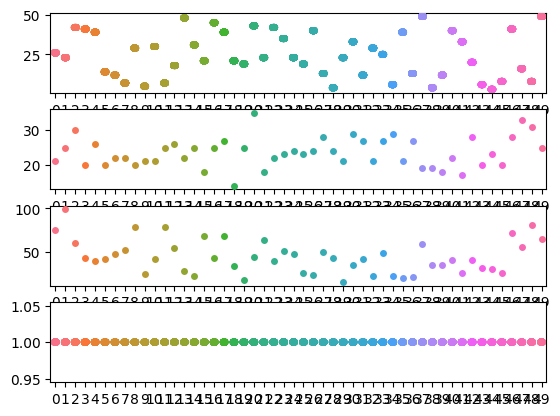

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axs = plt.subplots(nrows=4)
df = pd.DataFrame(list(data["Utility (Agent 1)"]))
sns.stripplot(data=df, ax=axs[0]);
df = pd.DataFrame([list(data["Utility (Agent 2)"])[99]])
sns.stripplot(data=df, ax=axs[1]);
df = pd.DataFrame([list(data["Utility (Agent 3)"])[99]])
sns.stripplot(data=df, ax=axs[2])
df = pd.DataFrame(list(data["Utility (Agent 4)"]))
sns.stripplot(data=df, ax=axs[3]);

**¿Cuál es el ambiente?**
Todos los agentes creados y su wealth.

**¿Qué sería lo análogo a la función de percepción "see()"?**
Es equivalente a la parte donde puede visualizar a todos los agentes.

**¿Cuáles son los perceptos?**
En la mayoría de los casos, observa un agente y elige uno al azar.

**¿Qué sería lo análogo a la función de decisión de acciones "next()"?**
Lo análogo a la función next es la parte donde evalua funciones booleanas de acuerdo al estado interno del agente y la del que fue escogido.

**¿Cuáles son los estados internos del agente?**
Utility y Wealth.

**¿Qué sería lo análogo a la función de acción "action()"?**
Esto sería donde se lleva a cabo la acción de intercambio de dinero entre agentes.

**¿Cuáles son las acciones posibles?**
Quitar dinero, dar dinero y no hacer nada.